<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/Hair_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
import tensorflow as tf
import keras.backend as K
import pandas as pd
import datetime
import sys
import tensorflow_addons as tfa
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.io import imread
from tqdm import tqdm
from google.colab import drive
from keras import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from keras.preprocessing.image import save_img
from skimage import io
drive.mount('/content/drive')
AUTOTUNE = tf.data.experimental.AUTOTUNE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def parse_data(image_path):
  image_content = tf.io.read_file(image_path)
  mask_path = image_path
  mask_path = tf.strings.regex_replace(mask_path, "images", "masks")
  mask_path = tf.strings.regex_replace(mask_path,"png","jpg")
  
  masks_content = tf.io.read_file(mask_path)
  
  images = tf.image.decode_jpeg(image_content, channels=1)
  masks = tf.image.decode_png(masks_content, channels=1)
  images = tf.image.resize(images,(128,128))
  images = tf.cast(images,tf.float32) /255.0 #cast images as tensor of type tf.float32 

  masks = tf.image.resize(masks,(128,128))
  masks = tf.cast(masks, tf.float32)/ 255.0
  
  return images, masks

def parse_images(path):
  content = tf.io.read_file(path)
  images = tf.image.decode_jpeg(content,channels=1)
  images = tf.image.resize(images,(128,128))
  images = tf.cast(images,tf.float32) / 255.0
  return images

In [7]:
img_path = '/content/drive/My Drive/hair_segmentation/cs4210-fall2020-assignment-3/images/images'
mask_path = '/content/drive/My Drive/hair_segmentation/cs4210-fall2020-assignment-3/masks/masks'
pred_path = '/content/drive/MyDrive/hair_segmentation/cs4210-fall2020-assignment-3/testing_images/testing_images'

images =  [os.path.join(img_path, x) for x in os.listdir(img_path) if x.endswith('.jpg')]
predictions = [os.path.join(pred_path,x) for x in os.listdir(pred_path) if x.endswith('.jpg')]
predictions.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

In [8]:
training_path, testing_path = train_test_split(images, test_size=0.2, random_state=42)
training_path, valid_image_path = train_test_split(training_path, test_size=0.2, random_state=42)
test_set = np.zeros((len(predictions), 128,128,1))
for i in range(len(predictions)):
  test_set[i] = parse_images(predictions[i])


TRAIN_DATASET_SIZE = len(training_path)
VALID_DATASET_SIZE = len(valid_image_path)
TEST_DATASET_SIZE = len(testing_path)
PRED_DATASET_SIZE = len(predictions)
#training set:
training_dataset_path = tf.data.Dataset.from_tensor_slices((training_path))
training_dataset = training_dataset_path.map(parse_data, num_parallel_calls=AUTOTUNE)

#validation set:
validation_path = tf.data.Dataset.from_tensor_slices((valid_image_path))
validation_dataset = validation_path.map(parse_data, num_parallel_calls=AUTOTUNE)

# testing set:
testing_dataset_path = tf.data.Dataset.from_tensor_slices((testing_path))
testing_dataset = testing_dataset_path.map(parse_data, num_parallel_calls=AUTOTUNE)

In [9]:
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.show()
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    # print(display_list[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray'  )
    plt.axis('off')
  plt.show()



In [10]:
# print(training_path)
BATCH_SIZE = 32
BUFFER_SIZE = 1000

training_dataset_batch = training_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
training_dataset_batch = training_dataset_batch.prefetch(buffer_size=AUTOTUNE)

validation_dataset_batch = validation_dataset.cache().repeat().batch(BATCH_SIZE)
validation_dataset_batch = validation_dataset_batch.prefetch(buffer_size=AUTOTUNE)

testing_dataset_batch = testing_dataset.cache().batch(BATCH_SIZE)
testing_dataset_batch = testing_dataset_batch.prefetch(buffer_size=AUTOTUNE)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

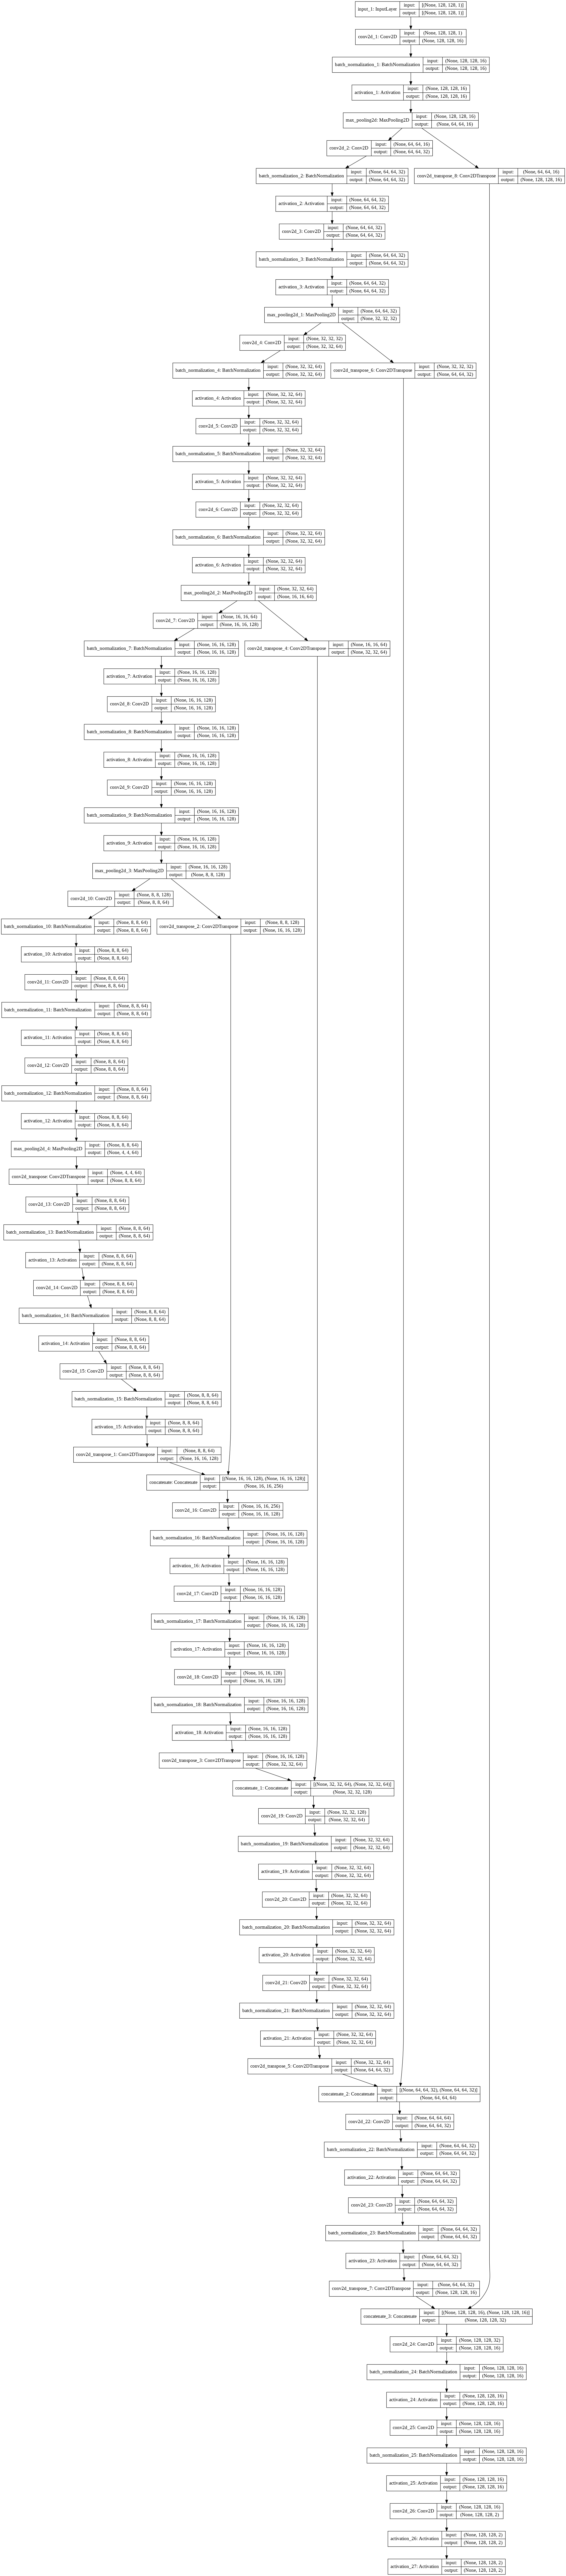

In [11]:
seg_in = Input((128,128,1))

augmentation = RandomFlip('horizontal', input_shape=(128,128,1))(seg_in)
augmentation = RandomRotation(0.3)(augmentation)
augmentation = RandomZoom(0.4)(augmentation)
augmentation = RandomContrast(0.2)(augmentation)


#-------- 1st Convolution --------
layer_1 = Conv2D(16,(3,3), padding='same')(augmentation)
layer_1 = BatchNormalization()(layer_1)
layer_1 = Activation('relu')(layer_1)
# #-------- 2nd Convolution -------- 
layer_1 = Conv2D(16,(3,3), padding='same')(seg_in)
layer_1 = BatchNormalization()(layer_1)
layer_1 = Activation('relu')(layer_1)
p_1 = MaxPooling2D(pool_size=(2,2))(layer_1)

#-------- 3rd Convolution --------
layer_2 = Conv2D(32,(3,3), padding='same')(p_1)
layer_2 = BatchNormalization()(layer_2)
layer_2 = Activation('relu')(layer_2)
# # #-------- 4th Convolution --------
layer_2 = Conv2D(32,(3,3), padding='same')(layer_2)
layer_2 = BatchNormalization()(layer_2)
layer_2 = Activation('relu')(layer_2)
p_2 = MaxPooling2D(pool_size=(2,2))(layer_2)

#-------- 5th Convolution --------
layer_3 = Conv2D(64,(3,3), padding='same')(p_2)
layer_3 = BatchNormalization()(layer_3)
layer_3 = Activation('relu')(layer_3)
#-------- 6th Convolution --------
layer_3 = Conv2D(64,(3,3), padding='same')(layer_3)
layer_3 = BatchNormalization()(layer_3)
layer_3 = Activation('relu')(layer_3)
# # #-------- 7th Convolution --------
layer_3 = Conv2D(64,(3,3), padding='same')(layer_3)
layer_3 = BatchNormalization()(layer_3)
layer_3 = Activation('relu')(layer_3)
p_3 = MaxPooling2D(pool_size=(2,2))(layer_3)

#-------- 8th Convolution --------
layer_4 = Conv2D(128,(3,3), padding='same')(p_3)
layer_4 = BatchNormalization()(layer_4)
layer_4 = Activation('relu')(layer_4)
#-------- 9th Convolution --------
layer_4 = Conv2D(128,(3,3), padding='same')(layer_4)
layer_4 = BatchNormalization()(layer_4)
layer_4 = Activation('relu')(layer_4)
# # #-------- 10th Convolution --------
layer_4 = Conv2D(128,(3,3), padding='same')(layer_4)
layer_4 = BatchNormalization()(layer_4)
layer_4 = Activation('relu')(layer_4)
p_4 = MaxPooling2D(pool_size=(2,2))(layer_4)

# #-------- 11th Convolution --------
layer_5 = Conv2D(64,(3,3), padding='same')(p_4)
layer_5 = BatchNormalization()(layer_5)
layer_5 = Activation('relu')(layer_5)
#-------- 12th Convolution --------
layer_5 = Conv2D(64,(3,3), padding='same')(layer_5)
layer_5 = BatchNormalization()(layer_5)
layer_5 = Activation('relu')(layer_5)
# # #-------- 13th Convolution --------
layer_5 = Conv2D(64,(3,3), padding='same')(layer_5)
layer_5 = BatchNormalization()(layer_5)
layer_5 = Activation('relu')(layer_5)
p_5 = MaxPooling2D(pool_size=(2,2))(layer_5)


upsampling_5 = Conv2DTranspose(64, (2, 2), strides=(2, 2))(p_5)  
#-------- 14th Convolution --------
layer_6 = Conv2D(64,(3,3), padding='same')(upsampling_5)
layer_6 = BatchNormalization()(layer_6)
layer_6 = Activation('relu')(layer_6)
# #-------- 15th Convolution --------
layer_6 = Conv2D(64,(3,3), padding='same')(layer_6)
layer_6 = BatchNormalization()(layer_6)
layer_6 = Activation('relu')(layer_6)
# #-------- 16th Convolution --------
layer_6 = Conv2D(64,(3,3), padding='same')(layer_6)
layer_6 = BatchNormalization()(layer_6)
layer_6 = Activation('relu')(layer_6)
layer_6 = Conv2DTranspose(128, (2, 2), strides=(2, 2))(layer_6)

upsampling_4 =Conv2DTranspose(128, (2, 2), strides=(2, 2))(p_4)
upsampling_4 = concatenate([upsampling_4,layer_6])
#-------- 16th Convolution --------
layer_7 = Conv2D(128,(3,3), padding='same')(upsampling_4)
layer_7 = BatchNormalization()(layer_7)
layer_7 = Activation('relu')(layer_7)
#-------- 17th Convolution --------
layer_7 = Conv2D(128,(3,3), padding='same')(layer_7)
layer_7 = BatchNormalization()(layer_7)
layer_7 = Activation('relu')(layer_7)
# # #-------- 18th Convolution --------
layer_7 = Conv2D(128,(3,3), padding='same')(layer_7)
layer_7 = BatchNormalization()(layer_7)
layer_7 = Activation('relu')(layer_7)
layer_7 = Conv2DTranspose(64,(2,2), strides=(2,2))(layer_7)


upsampling_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2))(p_3)
upsampling_3 = concatenate([upsampling_3,layer_7])
#-------- 19th Convolution --------
layer_8 = Conv2D(64,(3,3), padding='same')(upsampling_3)
layer_8 = BatchNormalization()(layer_8)
layer_8 = Activation('relu')(layer_8)
#-------- 20th Convolution --------
layer_8 = Conv2D(64,(3,3), padding='same')(layer_8)
layer_8 = BatchNormalization()(layer_8)
layer_8 = Activation('relu')(layer_8)
# #-------- 21th Convolution --------
layer_8 = Conv2D(64,(3,3), padding='same')(layer_8)
layer_8 = BatchNormalization()(layer_8)
layer_8 = Activation('relu')(layer_8)
layer_8 = Conv2DTranspose(32,(2,2), strides=(2,2))(layer_8)


upsampling_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2))(p_2)
upsampling_2 = concatenate([upsampling_2,layer_8])
#-------- 22th Convolution --------
layer_9 = Conv2D(32,(3,3), padding='same')(upsampling_2)
layer_9 = BatchNormalization()(layer_9)
layer_9 = Activation('relu')(layer_9)
#-------- 23th Convolution --------
layer_9 = Conv2D(32,(3,3), padding='same')(layer_9)
layer_9 = BatchNormalization()(layer_9)
layer_9 = Activation('relu')(layer_9)
layer_9 = Conv2DTranspose(16,(2,2), strides=(2,2))(layer_9)

upsampling_1 = Conv2DTranspose(16, (2, 2), strides=(2, 2))(p_1)
upsampling_1 = concatenate([upsampling_1,layer_9])
#-------- 24th Convolution --------
layer_10 = Conv2D(16,(3,3), padding='same')(upsampling_1)
layer_10 = BatchNormalization()(layer_10)
layer_10 = Activation('relu')(layer_10)
# #-------- 25th Convolution --------
layer_10 = Conv2D(16,(3,3), padding='same')(layer_10)
layer_10 = BatchNormalization()(layer_10)
layer_10 = Activation('relu')(layer_10)

layer_10 = Conv2D(2,(1,1))(layer_10) 
layer_10 = Activation('softmax')(layer_10)
seg_out = Activation('softmax')(layer_10)
seg_model = Model(inputs=[seg_in],outputs=[seg_out])
seg_model.summary()

tf.keras.utils.plot_model(seg_model, show_shapes=True)

In [12]:
# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
  '''x: numpy array of shape (height, width), 1 - mask, 0 - background
  Returns run length as list
  '''
  dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
  run_lengths = []
  prev = -2
  for b in dots:
    if (b>prev+1): run_lengths.extend((b+1, 0))
    run_lengths[-1] += 1
    prev = b
  return run_lengths

from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

def create_mask(pred_mask):
  print(pred_mask.shape)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  print(pred_mask.shape)
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image in dataset.take(num):
      pred_mask = seg_model.predict(image)
      print(pred_mask.shape)
      print('prediction with dataset')
      mask = create_mask(pred_mask)
      display([image[0],  create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(seg_model.predict(sample_image[tf.newaxis]))])


In [13]:
seg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
EPOCHS = 40
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_DATASET_SIZE//BATCH_SIZE
VALIDATION_STEPS = VALID_DATASET_SIZE//BATCH_SIZE//VAL_SUBSPLITS

model_history = seg_model.fit(training_dataset_batch, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset_batch)

Epoch 1/40
80/80 [==============================] - 947s 7s/step - loss: 0.5335 - accuracy: 0.7636 - val_loss: 0.5210 - val_accuracy: 0.8323
Epoch 2/40
80/80 [==============================] - 8s 97ms/step - loss: 0.4009 - accuracy: 0.8477 - val_loss: 0.3934 - val_accuracy: 0.8572
Epoch 3/40
80/80 [==============================] - 9s 107ms/step - loss: 0.3818 - accuracy: 0.8542 - val_loss: 0.3744 - val_accuracy: 0.8572
Epoch 4/40
80/80 [==============================] - 7s 90ms/step - loss: 0.3760 - accuracy: 0.8532 - val_loss: 0.3670 - val_accuracy: 0.8572
Epoch 5/40
80/80 [==============================] - 7s 91ms/step - loss: 0.3687 - accuracy: 0.8581 - val_loss: 0.3645 - val_accuracy: 0.8577
Epoch 6/40
80/80 [==============================] - 8s 95ms/step - loss: 0.3626 - accuracy: 0.8640 - val_loss: 0.3950 - val_accuracy: 0.8381
Epoch 7/40
80/80 [==============================] - 7s 92ms/step - loss: 0.3607 - accuracy: 0.8666 - val_loss: 0.3593 - val_accuracy: 0.8625
Epoch 8/40
8

In [15]:
test_history = seg_model.evaluate(testing_dataset_batch)

26/26 [==============================] - 266s 10s/step - loss: 0.3368 - accuracy: 0.8904


In [ ]:
seg_history = seg_model.predict(test_set)

In [17]:
def save_prediction_masks(predict, path):
    pred_mask = tf.argmax(predict,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    for i in range(predict.shape[0]):
        prediction_path = os.path.join(path + 'test_mask_' + str(i+1) + '.jpg')
        mask_gray = pred_mask[i]
        mask = np.concatenate((mask_gray,mask_gray),axis=-1)
        mask = np.concatenate((mask,mask_gray),axis=-1)
        save_img(prediction_path,tf.keras.preprocessing.image.array_to_img(mask),channels=1,scale=False)



In [ ]:
# (* update) the input_path using your folder path
input_path = '/content/drive/MyDrive/hair_segmentation/cs4210-fall2020-assignment-3/predictions/predictions/'

save_prediction_masks(seg_history,input_path) #save masks before converting to csv

# # # get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))
print(masks)

# # encode all masks
encodings = []
for i, file in tqdm(enumerate(masks), total=len(masks)):
  mask = imread(os.path.join(input_path, file))
  #img_size =10
  mask = resize(mask, (250, 250), mode='constant', preserve_range=True)
  mask = rgb2gray(mask)
  mask = np.array(mask, dtype=np.uint8)
  mask = np.round(mask/255)
  encodings.append(rle_encoding(mask))

# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('/content/drive/MyDrive/hair_segmentation/cs4210-fall2020-assignment-3/predictions/masks/', 'test_mask_preds_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv'), index=False)
sys.stdout.flush()